# Pacotes

In [15]:
import re
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
import wordcloud
from langdetect import detect_langs
import pandas as pd
from  sklearn.feature_extraction.text import CountVectorizer

import html

import sys
sys.path.append('/Análise de sentimentos/outros/LBC/LBC/')
from LBC import LBC


sys.path.append('/Análise de sentimentos/outros/LeIA-master/')

from leia import SentimentIntensityAnalyzer 

# Tratamento dos dados

In [2]:
ambev = pd.read_csv("ambev.csv",index_col=0).iloc[0:100,:] #reduzindo a amostra de dados

In [3]:
ambev

,date,content
0,2021-11-21 20:06:44+00:00,I'm at Ambev - CDD Bebedouro https://t.co/Sy5f...
1,2021-11-21 19:35:28+00:00,Todo nicolas cagevannuccinho @ambev @brahmacer...
2,2021-11-21 17:07:37+00:00,"Depois de ontem se a AmBev não falir, não fali..."
3,2021-11-21 15:58:06+00:00,"Fiz cadastro com CNPJ na ambev, tem polar lá n..."
4,2021-11-21 02:31:07+00:00,Drinking a Chopp Brahma by AmBev at @bar_brahm...
...,...,...
95,2021-11-13 02:48:23+00:00,@Ambev dobra a produção
96,2021-11-12 22:44:44+00:00,"@Clauwild1 E dos ""empresários"" da trupe do Mag..."
97,2021-11-12 22:14:33+00:00,"Que corja de gente ruim é essa, Jesus?\n@rocar..."
98,2021-11-12 20:08:56+00:00,experimentei uma cerveja nova da ambev gostosa...


### Identificando idiomas (é possível que venham tweets em espanhol , imagino que a análise de sentimento nesse caso seaj um pouco diferente)

In [4]:
idiomas = []

for row in range(len(ambev)):
    idiomas.append(detect_langs(ambev.iloc[row,1]))

In [5]:
type(idiomas[2][0])

langdetect.language.Language

In [6]:
idiomas[2][0]

pt:0.999995286597987

In [7]:
ambev['Idiomas'] = idiomas

In [8]:
for i in idiomas:
    print(str(i[0]).split(":")[0])

da
pt
pt
pt
en
pt
pt
pt
pt
pt
da
pt
pt
pt
pt
pt
pt
en
pt
pt
pt
pt
pt
sl
pt
pt
pt
pt
pt
pt
en
pt
pt
ca
tl
pt
pt
pt
pt
pt
so
pt
pt
pt
vi
pt
pt
pt
pt
pt
pt
pt
pt
pt
pt
es
pt
it
pt
it
pt
it
it
it
en
pt
pt
sk
pt
pt
ca
pt
pt
tl
pt
pt
hu
ca
pt
pt
pt
sk
nl
pt
pt
pt
pt
pt
pt
de
pt
pt
it
pt
pt
pt
pt
pt
pt
nl


In [9]:
ambev['Idiomas'] = ambev['Idiomas'].copy().apply(lambda row: str(row[0]).split(":")[0])

In [10]:
ambev['Idiomas'].value_counts()

pt    73
it     6
en     4
ca     3
da     2
tl     2
sk     2
nl     2
sl     1
so     1
vi     1
es     1
hu     1
de     1
Name: Idiomas, dtype: int64

In [11]:
ambev[ambev['Idiomas'] == "de"] # acredito que o algoritmo considerou mts coisas como não sendo pt-bt (o código pega a lingua com maior chance de ser)

,date,content,Idiomas
89,2021-11-13 16:37:20+00:00,Mente Vazia e Oficina Da AmBev e Johnnie Walke...,de


In [12]:
ambev = ambev[ambev['Idiomas'] != "en"] 

### Limpeza

In [13]:
import warnings
warnings.filterwarnings("ignore")

ambev['texto'] = ambev['content'].copy()

ambev['texto'] = ambev['texto'].apply(lambda x : x.lower()) # deixando as letras em minusculo 

ambev['texto'] = ambev['texto'].apply(lambda x :  html.unescape(x)) # decode html

ambev['texto'] = ambev['texto'].apply(lambda x :  re.sub(r'@[A-Za-z0-9]+','',x)) # retirando menções @

ambev['texto'] = ambev['texto'].apply(lambda x :  re.sub('https?://[A-Za-z0-9./]+','',x)) # retirando URLs



In [14]:
ambev['texto']

0                         i'm at ambev - cdd bebedouro 
1     todo nicolas cagevannuccinho   em goiânia, bra...
2     depois de ontem se a ambev não falir, não fali...
3     fiz cadastro com cnpj na ambev, tem polar lá n...
5                      alô ambev dobra a produção aí… 🎵
                            ...                        
95                                     dobra a produção
96     e dos "empresários" da trupe do magazine luiz...
97    que corja de gente ruim é essa, jesus?\n você ...
98    experimentei uma cerveja nova da ambev gostosa...
99       alôooooooooooo ambev..... vem me consola 😥😥😥\n
Name: texto, Length: 96, dtype: object

----

In [15]:
ambev['texto'].iloc[95]

'alôooooooooooo ambev..... vem me consola 😥😥😥\n'

# Testando LBC

### Primeiros passos

In [16]:
classifier = LBC("/home/eduardo/Documentos/Projetos Extras/Análise de sentimentos/outros/LBC/LBC/data/LIWC2007_Portugues_win.dic.txt")

In [17]:
classifier.classify(text="eu odeio cerveja")

-1

In [18]:
classifier.classify(text="eu amo cerveja")

1

In [19]:
classifier.classify(text="cerveja tanto faz")

0

In [20]:
classifier.classify(text="eu não amo cerveja")

-1

In [96]:
classifier.classify(text="eu morro de amores por você")

1

In [21]:
classifier.get_polarity("amor")

1

In [22]:
classifier.get_polarity("ódio")

-1

In [23]:
classifier.get_polarity("cerveja")

0

In [24]:
classifier.get_polarity("morte")

-1

### Removendo stopwords

In [26]:
# remover "stopwords" da lingua portuguesa 

nltk.download('stopwords')


ptbr_stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eduardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
#ptbr_stopwords

In [45]:
"não" in ptbr_stopwords

False

In [29]:
ptbr_stopwords.remove("não") # não é uma stopword importante

In [30]:
"não" in ptbr_stopwords

False

In [39]:
def remove_stop_words(texto,stopwords):
  
    # seleciona apenas letras e coloca todas em minúsculo 
    letras_min =  re.findall(r'\b[A-zÀ-úü]+\b', texto.lower())

    # remove stopwords
    stop = set(stopwords)
    sem_stopwords = [w for w in letras_min if w not in stop]

    # juntando os tokens novamente em formato de texto
    texto_limpo = (" ").join(sem_stopwords)

    return texto_limpo

In [40]:
remove_stop_words(ambev['texto'].iloc[95],ptbr_stopwords)

'alôooooooooooo ambev vem consola'

### Classificando os textos do dataset com base no LBC

In [42]:
ambev['texto'].apply(lambda row: remove_stop_words(row,ptbr_stopwords))

0                            i m at ambev cdd bebedouro
1           todo nicolas cagevannuccinho goiânia brazil
2     ontem ambev não falir não fali misericórdia ta...
3     fiz cadastro cnpj ambev polar lá black friday ...
5                           alô ambev dobra produção aí
                            ...                        
95                                       dobra produção
96    empresários trupe magazine luiza natura itaú a...
97    corja gente ruim jesus culpado tudo tomara pat...
98    experimentei cerveja nova ambev gostosa pra ca...
99                     alôooooooooooo ambev vem consola
Name: texto, Length: 96, dtype: object

In [44]:
ambev['texto_sem_stopwords'] = ambev['texto'].apply(lambda row: remove_stop_words(row,ptbr_stopwords)) # removendo stopwords

In [47]:
ambev['Sentimento_LBC_com_SW'] = ambev['texto'].apply(lambda row : classifier.classify(text=row)) # aplicando o LBC  com stopwords nos textos

In [48]:
ambev['Sentimento_LBC_sem_SW'] = ambev['texto_sem_stopwords'].apply(lambda row : classifier.classify(text=row)) # aplicando o LBC  sem stopwords nos textos

In [49]:
ambev[['Sentimento_LBC_com_SW','Sentimento_LBC_sem_SW']]

,Sentimento_LBC_com_SW,Sentimento_LBC_sem_SW
0,0.0,0
1,0.0,0
2,1.0,2
3,0.0,0
5,0.0,0
...,...,...
95,0.0,0
96,0.0,0
97,-2.0,-2
98,0.0,0


In [53]:
# comparando - há uma diferença na "intensidade" do sentimento
print("Média da diferença absoluta", (ambev['Sentimento_LBC_com_SW'] - ambev['Sentimento_LBC_sem_SW']).abs().mean() )
print("Desvio padrão da diferença absoluta", (ambev['Sentimento_LBC_com_SW'] - ambev['Sentimento_LBC_sem_SW']).abs().std() )

Média da diferença absoluta 0.2673611111111111
Desvio padrão da diferença absoluta 0.7248630306860467


----

# Testando o leia (Vader) 

OBS: segundo os autores não há  a necessidade de pré-processamento

In [56]:
sentiment_analyzer_leia = SentimentIntensityAnalyzer()


In [57]:

# Análise de texto simples
sentiment_analyzer_leia.polarity_scores('Gosto de cerveja')



{'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'compound': 0.4019}

In [60]:

# Análise de texto com emoji :)
sentiment_analyzer_leia.polarity_scores('Amo cerveja da ambev :)')

{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'compound': 0.4588}

In [65]:

# Análise de texto com emoji :)
sentiment_analyzer_leia.polarity_scores('Gosto de cerveja :)')

{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compound': 0.6908}

In [66]:

# Análise de texto com emoji :)
sentiment_analyzer_leia.polarity_scores('Amo uma cerveja :)')

{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.4588}

In [67]:

# Análise de texto com emoji :) - não fez diferença as letras maiúsculas 
sentiment_analyzer_leia.polarity_scores('ADORO BEBER CERVEJA :)')

{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.4588}

In [61]:

# Análise de texto com negativo
sentiment_analyzer_leia.polarity_scores('Odeio cerveja ,acho nojento')


{'neg': 0.78, 'neu': 0.22, 'pos': 0.0, 'compound': -0.7964}

In [62]:

# Análise de texto com negação
sentiment_analyzer_leia.polarity_scores('Não gosto de cerveja')


{'neg': 0.319, 'neu': 0.29, 'pos': 0.391, 'compound': 0.128}

In [64]:

# Análise de texto com negação - propositalmente confuso
sentiment_analyzer_leia.polarity_scores('Não odeio cerveja, gosto bastante')


{'neg': 0.535, 'neu': 0.198, 'pos': 0.267, 'compound': -0.4019}

In [70]:
ambev['sentiment_score_LEIA_VADER'] = ambev['texto'].apply(lambda row : sentiment_analyzer_leia.polarity_scores(row)['compound'])

In [71]:
def rotula_sentimento_LV(sentiment_score):
    if sentiment_score >= 0.05:
        label = "positivo"
    elif sentiment_score <= -0.05: 
        label = "negativo"
    else:
        label = 'neutro'

    return(label)

In [73]:
rotula_sentimento_LV(0.1)

'positivo'

In [75]:
ambev['Sentimento_label_LEIA_VADER'] = ambev['sentiment_score_LEIA_VADER'].apply(lambda row : rotula_sentimento_LV(row))

In [76]:
ambev['Sentimento_label_LEIA_VADER'].value_counts()

neutro      41
negativo    29
positivo    26
Name: Sentimento_label_LEIA_VADER, dtype: int64

In [85]:
ambev.columns

Index(['date', 'content', 'Idiomas', 'texto', 'texto_sem_stopwords',
       'Sentimento_LBC_com_SW', 'Sentimento_LBC_sem_SW',
       'sentiment_score_LEIA_VADER', 'Sentimento_label_LEIA_VADER'],
      dtype='object')

In [86]:
ambev[['date','sentiment_score_LEIA_VADER']]

,date,sentiment_score_LEIA_VADER
0,2021-11-21 20:06:44+00:00,0.0000
1,2021-11-21 19:35:28+00:00,0.0000
2,2021-11-21 17:07:37+00:00,-0.5106
3,2021-11-21 15:58:06+00:00,0.0000
5,2021-11-20 23:24:16+00:00,-0.4215
...,...,...
95,2021-11-13 02:48:23+00:00,0.0000
96,2021-11-12 22:44:44+00:00,0.0000
97,2021-11-12 22:14:33+00:00,-0.8122
98,2021-11-12 20:08:56+00:00,0.0000


----

# Visualizando as informações

### WordCloud ambev

In [77]:
ambev_word_cloud = WordCloud(background_color="black", stopwords=ptbr_stopwords).generate(str(ambev['content']))

In [78]:
ambev_WC_sem_stopword = WordCloud(background_color="black").generate(str(ambev['content']))

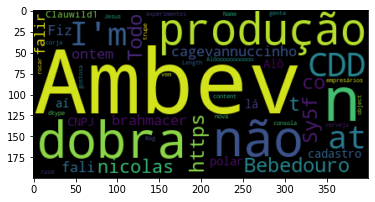

In [79]:
plt.imshow(ambev_word_cloud,interpolation="bilinear")

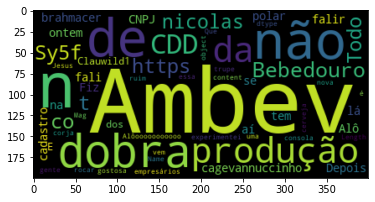

In [80]:
plt.imshow(ambev_WC_sem_stopword,interpolation="bilinear")

In [81]:
ambev_word_cloud_V2 = WordCloud(background_color="black", stopwords=ptbr_stopwords).generate(str(ambev['texto']))

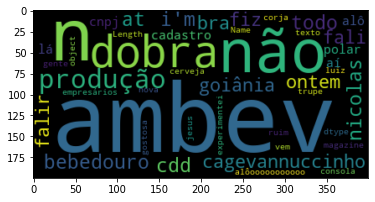

In [82]:
plt.imshow(ambev_word_cloud_V2,interpolation="bilinear")

In [83]:
ambev_WC_sem_stopword_V2 = WordCloud(background_color="black").generate(str(ambev['texto']))

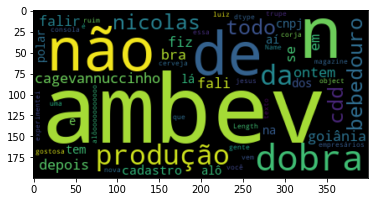

In [84]:
plt.imshow(ambev_WC_sem_stopword_V2,interpolation="bilinear")

### 

In [94]:
ambev_word_cloud_V3 = WordCloud(background_color="black", stopwords=ptbr_stopwords + ['ambev',"Ambev"]).generate(str(ambev['content']))

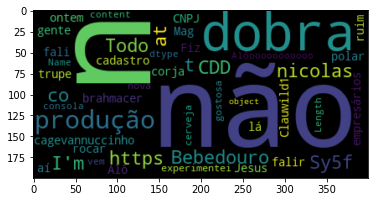

In [95]:
plt.imshow(ambev_word_cloud_V3,interpolation="bilinear")